# Fun with LinkedIn Queens

We start with installing (or checking) that we have access to OR-tools for constraint solving and to Pillow for manipulating images in python.

In [ ]:
!pip install -U --user ortools
!pip install -U --user Pillow

In [2]:
import itertools as it
from matplotlib import pyplot as plt
import numpy as np
import ortools
import pathlib as paths
from PIL import Image, ImageOps
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
rng = np.random.default_rng(seed=2024)

Look for the screenshots of puzzles collected so far.

In [3]:
que_dir = paths.Path('screenshots')
puzzles = []
thumbs = []
for f_img in list(que_dir.glob("*png")):
    with Image.open(f_img) as im:
        small = ImageOps.contain(im, (128,128)).convert('RGBA')
        pixels = np.array(small)
        thumbs.append(small)
        puzzles.append(pixels[:,:,:3])
print(f"Found {len(puzzles)} puzzles.")

Found 45 puzzles.


The main work of figuring out what we're looking at is done in `learnPalette`.  A number of random starting positions are chosen in the image.  From each starting position, we explore a few nearby pixels and if we find the same colour as the starting pixel (or close enough) then we make it a candidate colour for the puzzle.  However, if we come across a pixel that's different, we back out and forget the colour of the starting pixel.

=== Doing puzzle # 0 === 

Found 9; Kept = 9
[[4 4 4 4 4 4 4 4 4]
 [7 4 4 1 1 1 4 4 4]
 [7 0 0 0 1 3 3 3 4]
 [7 7 7 0 5 5 5 3 4]
 [7 0 0 0 5 3 3 3 4]
 [7 0 2 2 2 2 2 3 4]
 [7 0 0 0 2 3 3 3 4]
 [7 7 7 7 7 6 6 4 4]
 [7 7 7 7 7 6 4 4 4]]
[[4, 4, 4, 4, 4, 4, 4, 4, 4], [7, 4, 4, 1, 1, 1, 4, 4, 4], [7, 0, 0, 0, 1, 3, 3, 3, 4], [7, 7, 7, 0, 5, 5, 5, 3, 4], [7, 0, 0, 0, 5, 3, 3, 3, 4], [7, 0, 2, 2, 2, 2, 2, 3, 4], [7, 0, 0, 0, 2, 3, 3, 3, 4], [7, 7, 7, 7, 7, 6, 6, 4, 4], [7, 7, 7, 7, 7, 6, 4, 4, 4]]
=== Doing puzzle # 1 === 

Found 10; Kept = 10
[[8 8 8 8 8 8 8 3 3 3]
 [8 8 8 8 8 0 8 8 3 3]
 [8 8 8 4 4 0 0 8 8 3]
 [8 8 4 4 2 2 0 0 8 8]
 [1 1 4 2 2 8 8 2 2 8]
 [8 1 1 2 8 8 2 2 8 8]
 [8 8 1 8 8 8 2 8 8 8]
 [8 8 8 8 5 8 8 8 7 8]
 [8 8 8 5 5 8 8 7 7 8]
 [8 8 5 5 8 8 7 7 8 8]]
[[8, 8, 8, 8, 8, 8, 8, 3, 3, 3], [8, 8, 8, 8, 8, 0, 8, 8, 3, 3], [8, 8, 8, 4, 4, 0, 0, 8, 8, 3], [8, 8, 4, 4, 2, 2, 0, 0, 8, 8], [1, 1, 4, 2, 2, 8, 8, 2, 2, 8], [8, 1, 1, 2, 8, 8, 2, 2, 8, 8], [8, 8, 1, 8, 8, 8, 2, 8, 8, 8], [8, 8, 8, 8, 5, 8, 8, 8, 7, 8], [8, 8, 8, 5, 5, 8, 8, 7, 7, 8], [8, 8, 5, 5, 8, 8, 7, 7, 8, 8]]
=== Doing puzzle # 2 === 

Found 9; Kept = 9
[[1 1 1 2 2 2 2 7 7]
 [1 1 0 2 2 2 2 7 7]
 [1 1 0 0 2 2 2 7 7]
 [1 1 0 2 2 2 2 4 7]
 [1 1 1 1 2 2 4 4 4]
 [1 3 1 1 1 2 4 6 4]
 [3 3 3 1 1 2 6 6 6]
 [3 7 3 2 2 2 2 2 2]
 [7 7 7 2 2 2 2 2 2]]
[[1, 1, 1, 2, 2, 2, 2, 7, 7], [1, 1, 0, 2, 2, 2, 2, 7, 7], [1, 1, 0, 0, 2, 2, 2, 7, 7], [1, 1, 0, 2, 2, 2, 2, 4, 7], [1, 1, 1, 1, 2, 2, 4, 4, 4], [1, 3, 1, 1, 1, 2, 4, 6, 4], [3, 3, 3, 1, 1, 2, 6, 6, 6], [3, 7, 3, 2, 2, 2, 2, 2, 2], [7, 7, 7, 2, 2, 2, 2, 2, 2]]
=== Doing puzzle # 3 === 

Found 10; Kept = 10
[[4 4 8 8 8 0 0 2 2 2]
 [4 4 4 8 0 0 0 2 2 2]
 [4 4 4 8 8 0 0 2 2 2]
 [4 4 4 8 0 0 0 2 5 2]
 [4 4 8 8 8 0 0 2 5 2]
 [4 1 1 1 8 7 3 7 5 5]
 [4 1 1 8 8 7 3 7 5 5]
 [4 1 1 1 8 7 7 7 5 5]
 [4 4 4 1 8 8 7 5 5 5]
 [4 1 1 1 8 8 7 5 5 5]]
[[4, 4, 8, 8, 8, 0, 0, 2, 2, 2], [4, 4, 4, 8, 0, 0, 0, 2, 2, 2], [4, 4, 4, 8, 8, 0, 0, 2, 2, 2], [4, 4, 4, 8, 0, 0, 0, 2, 5, 2], [4, 4, 8, 8, 8, 0, 0, 2, 5, 2], [4, 1, 1, 1, 8, 7, 3, 7, 5, 5], [4, 1, 1, 8, 8, 7, 3, 7, 5, 5], [4, 1, 1, 1, 8, 7, 7, 7, 5, 5], [4, 4, 4, 1, 8, 8, 7, 5, 5, 5], [4, 1, 1, 1, 8, 8, 7, 5, 5, 5]]
=== Doing puzzle # 4 === 

Found 10; Kept = 10
[[2 2 2 2 1 1 2 2 0 0]
 [3 2 2 2 1 1 2 2 0 0]
 [3 3 2 1 1 1 1 0 0 4]
 [2 3 2 1 7 7 7 0 4 4]
 [2 2 2 1 1 1 7 0 4 0]
 [5 2 2 1 1 1 1 0 0 0]
 [5 2 2 8 8 8 1 0 8 8]
 [5 2 2 1 8 1 1 0 8 0]
 [5 2 2 1 1 1 1 0 8 0]
 [2 2 2 2 1 1 1 0 0 0]]
[[2, 2, 2, 2, 1, 1, 2, 2, 0, 0], [3, 2, 2, 2, 1, 1, 2, 2, 0, 0], [3, 3, 2, 1, 1, 1, 1, 0, 0, 4], [2, 3, 2, 1, 7, 7, 7, 0, 4, 4], [2, 2, 2, 1, 1, 1, 7, 0, 4, 0], [5, 2, 2, 1, 1, 1, 1, 0, 0, 0], [5, 2, 2, 8, 8, 8, 1, 0, 8, 8], [5, 2, 2, 1, 8, 1, 1, 0, 8, 0], [5, 2, 2, 1, 1, 1, 1, 0, 8, 0], [2, 2, 2, 2, 1, 1, 1, 0, 0, 0]]
=== Doing puzzle # 5 === 

Found 9; Kept = 9
[[3 3 3 3 3 3 3 3 3]
 [3 3 7 3 0 0 0 3 3]
 [3 7 7 7 2 0 0 0 0]
 [3 3 7 2 2 2 2 0 0]
 [3 3 3 3 2 2 2 2 0]
 [3 4 4 4 1 0 2 0 0]
 [3 7 7 7 1 0 0 0 0]
 [3 7 7 7 1 6 6 6 0]
 [3 3 7 7 7 0 0 0 0]]
[[3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 7, 3, 0, 0, 0, 3, 3], [3, 7, 7, 7, 2, 0, 0, 0, 0], [3, 3, 7, 2, 2, 2, 2, 0, 0], [3, 3, 3, 3, 2, 2, 2, 2, 0], [3, 4, 4, 4, 1, 0, 2, 0, 0], [3, 7, 7, 7, 1, 0, 0, 0, 0], [3, 7, 7, 7, 1, 6, 6, 6, 0], [3, 3, 7, 7, 7, 0, 0, 0, 0]]


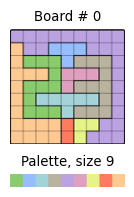

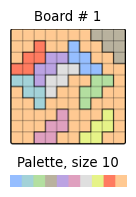

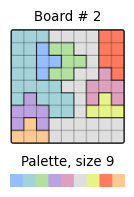

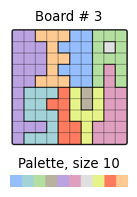

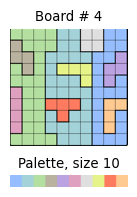

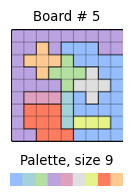

In [4]:
N_STA = int(1e4)
N_NEI = 16
D_NEI = 4
TOO_CLOSE = 3
PAL_WID = 32

def learnPalette(p, n_starts=N_STA, n_neighbours=N_NEI, dist_neighbours=D_NEI,
                 same_thresh=TOO_CLOSE):
    """Use the pixels in an image to work out the 'real' colours in a puzzle """
    keep = set()
    for _ in tqdm.tqdm(range(n_starts),leave=False):
        homeidx = tuple([rng.integers(x) for x in p.shape[:2]])
        homecol = p[homeidx]
        if homecol.sum() > 750 or homecol.sum() < 100: # ignore black and white
            continue
        good = True
        for _ in range(n_neighbours):
            newidx = np.array(homeidx) + np.array(rng.integers(dist_neighbours,size=2))
            try:
                newcol = p[tuple(newidx.tolist())]
            except IndexError: # looking outside the grid?
                good=False
                break
            if not np.array_equal(homecol,newcol):
                good=False
                break
        if good:
            keep.add(tuple(homecol.tolist()))
    # mark as a duplicate any colour which is close enough to another colour
    dupes = set(
        [b for a, b in it.combinations(keep,2)
         if np.max(np.abs(np.array(a)-np.array(b))) < same_thresh]
    )
    cols = keep - dupes
    print(f"Found {len(keep)}; Kept = {len(cols)}")
    return cols


def drawPuzzleAndPalette(p,cols):
    """Show the puzzle and the extracted palette"""
    pal = np.zeros(shape=(PAL_WID,len(cols)*PAL_WID,3),dtype=np.int8)
    for j, (r,g,b) in enumerate(sorted(cols)):
        pal[:,j*PAL_WID:(j+1)*PAL_WID] = np.array([r,g,b])
    fig,axs = plt.subplots(2,1,height_ratios=(len(cols),1),figsize=(1.6,2))
    plt.rcParams.update({'font.size': 8})
    ax = axs[0]
    ax.imshow(Image.fromarray(p))
    ax.set_axis_off()
    ax.set_title(f"Board #{i:2d}")
    ax = axs[1]
    ax.set_axis_off()
    ax.set_title(f"Palette, size {len(cols)}")
    ax.imshow(Image.fromarray(pal,mode='RGB'))
    fig.tight_layout()


def makeConstraintInstance(p,cols):
    """Generate a row,column parameter array to describe a given puzzle """
    # grab the central pixel of each cell
    n = len(cols)
    w = p.shape[0] / n
    centres = np.array([ [p[int(w/2+w*r)][int(w/2+w*c)]  for c in range(n)] for r in range(n)])
    # fix colours to nearest known
    for r,c in it.product(range(n),repeat=2):
        centres[r,c] = sorted(cols, key=lambda rgb:np.sum(np.abs(centres[r,c] - rgb)))[0]
    centre_cols = np.unique(np.array(centres).reshape(-1,3),axis=0)
    assert centre_cols.shape[0]==n, "Mismatch between colours in centres vs expected palette"
    board = [ [np.where(centre_cols==c)[0][0] for c in r] for r in centres]
    print(np.array(board))
    return board


puzzle_idxs = np.random.choice(range(len(puzzles)),replace=False,size=6)
for i, p in enumerate([puzzles[i] for i in puzzle_idxs]):
    print(f"=== Doing puzzle #{i:2d} === ",end='')
    cols = learnPalette(p)
    drawPuzzleAndPalette(p, cols)
    params = makeConstraintInstance(p, cols)
    print(params)
